In [1]:
# Python core Libraries
import sys
import os
import random as rnd
from os import listdir
from os.path import isfile, isdir, join
# Fundamental Libraries for Machine Learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from zipfile import ZipFile
import glob   # In order to get images as matrices from directory
import pickle

# Scikit-Learn Libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# Traditional Classification Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier  # Decision Tree Classifier
from sklearn.neighbors import KNeighborsClassifier # K Nearest Neighbor Classifier Algorithm
from sklearn.naive_bayes import GaussianNB # Naive Bayes Classifier
from sklearn.svm import SVC # Support Vector Machine Classifier
from sklearn.ensemble import RandomForestClassifier # Random Forest Classifier 
# Classification Evaluation metrics and Visualization
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score # Evaluation metrics
from sklearn.metrics import classification_report  # Precision, recall, f1-score metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Classifier Confusion Matrix visualization
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

# Tensorflow Libraries for Deep Neural Networks
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten, AveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import binary_crossentropy

In [2]:
BATCH_SIZE = 64        # Size of batches for each epoch (common used batch size 32 is not suitable for out data)
NUM_EPOCH = 60        # How many epoch will be used for model training
IMG_SIZE = (256,256)     # Input Image size
INPUT_SIZE = (256, 256, 3) # RGB format Image
CONT_MARGIN = 1       # Contrastive Loss margin
K_FOLD_VALID = 10     # K for cross validation
RND_STATE = 24        # Randomness constant for robust outputs

# Dataset Directory
# DATASET_DIR           = '/kaggle/input/mvtec-transistor-dataset/transistor/'           # Kaggle server workspace
DATASET_DIR           = '/Users/atalaypab/Downloads/Defect_Detection_DB/transistor/'   # MacOS Local workspace
# DATASET_DIR           = 'C:\\Users\\atalayp\\Downloads\\transistor\\'                    # Windows Local workspace
# Kaggle server workspace - MacOS Local workspace
DATA_TRAIN_POS_DIR    = DATASET_DIR + 'train/good/'
DATA_TEST_POS_DIR     = DATASET_DIR + 'test/good'
DATA_TEST_DIR         = DATASET_DIR + 'test/'
# Windows Local workspace
# DATA_TRAIN_POS_DIR    = DATASET_DIR + 'train\\good\\'
# DATA_TEST_POS_DIR     = DATASET_DIR + 'test\\good\\'
# DATA_TEST_DIR         = DATASET_DIR + 'test\\'
# Training and Testing Negative data will be gathering from test directory

In [3]:
# Each training and test example is assigned to one of the following labels:
labels = ["defect", "defect-free"]

In [4]:
class VisionBasics():
    def __init__(self) -> None:
        self.files = []
        self.formats = ['jpg', 'png', 'jpeg']  # Add valid image formats here
        self._project_directory()
        pass

    def _project_directory(self):
        if (str(sys.platform) == "darwin") or (str(sys.platform) == "linux"):    # MacOS or Linux Environment
            current_dir = os.getcwd() + "/"
        else:   # Windows Environment
            current_dir = os.getcwd() + "\\"
        self.files = os.listdir(current_dir)

    def get_files(self):
        return self.files

    def print_files_of_project_directory(self):
        print(self.files)

    def save_ml_model(self, model, tag='Model'):
        pickle.dump(model, open(tag, 'wb'))

    def load_ml_model(self, directory):
        return pickle.load(open(directory, 'rb'))

    # Example of usage change_img_file_format method:
    # change_img_file_format.open(r'C:\Users\Ron\Desktop\Test\summer.png', )
    # TODO: Continue to write this method
    def change_img_file_format(self, img_dir, src_format, dest_format):
        cnv_rgx_frmt = lambda frmt: '\.' + frmt + '$' 
        rgx_formats = map(cnv_rgx_frmt, self.formats)

        if any([(re.search(format, img_dir)!=None) for format in rgx_formats]):
            if dest_format in self.formats:
                if dest_format in img_dir[-5:]:
                    print("UserWarning: This image file is already {0} format".format(dest_format))
                else:
                    img = Image.open(img_dir)
                    img.save()
            else:
                raise ValueError("Invalid image format, use '.png', '.jpeg', '.jpg' file formats")    
        else:
            raise ValueError("Invalid image format, use '.png', '.jpeg', '.jpg' file formats")

    ''' DEEP LEARNING METHODS FOR COMPUTER VISION '''
    # Load the specified file as a tf.image and preprocess it (see valid image formats)
    # See tf.keras.preprocessing.image_dataset_from_directory (https://keras.io/api/preprocessing/image/)
    def get_imgs_from_directory_as_numpy_array(self, dir, ext, size=None, scl=None, version=2):
        if ext in self.formats:
            rgx_for_img = dir + "/*." + ext
            img_list = glob.glob(rgx_for_img)

            # Scale image
            # scl_img = lambda img: ((img.astype('float32'))/255.0)

            if version < 0:
                # Function V0.1 (Use version 1 if any incompatibility on CUDA GPU version and the tf)
                # Cleanup called error on virtual machine
                if size is None:
                    img_arr = np.array([np.array(Image.open(img)) for img in img_list])
                else:
                    img_arr = np.array([np.array(Image.open(img).resize(size)) for img in img_list])

                img_arr = img_arr.astype('float32')
                if scl == '8bit': img_arr /= 255.0
                    
                return img_arr
            elif version == 1:
                def process_images(filename):
                    img = keras.preprocessing.image.load_img(filename, color_mode="rgb", target_size=size)
                    img_arr = keras.preprocessing.image.img_to_array(img)
                    img_arr = np.array(img_arr).astype('float32')  
                    if scl == '8bit': img_arr /= 255.0
                    return img_arr
                
                return np.array(list(map(process_images, img_list)))
                # https://keras.io/api/preprocessing/image/
                # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
            else:
                def process_images(filename):
                    image_string = tf.io.read_file(filename)
                    # Decode a JPEG-encoded image to a uint8 tensor
                    # image = tf.image.decode_image(image_string, channels=3)  
                    image = tf.image.decode_image(image_string, channels=0)    
                    # channels: An optional int. Defaults to 0. Number of color channels for the decoded image
                    # Detects whether an image is a BMP, GIF, JPEG, or PNG, and performs the appropriate operation to convert 
                    # the input bytes string into a Tensor of type dtype.
                    image = tf.image.convert_image_dtype(image, tf.float32)
                    image = image.numpy()
                    if size != None:
                        image = tf.image.resize(image, size)
                    if scl == '8bit':
                        image /= 255.0
                    return image

                return list(map(process_images, img_list))
        else:
            raise ValueError("Invalid image format, use '.png', '.jpeg', '.jpg' file formats")

    # This method prepares a data array as a keras input
    # Example of input_size parameter usage: (28,28,1) -> 28x28 pixels gray scale images, (28,28,3) 28x28 pixels RGB images
    # Example of np_array parameter usage: np_array.shape = (60000, 28, 28) OR (60000, 784)
    def prepare_imgs_as_keras_input(self, np_array, input_size):
        w, h, d = input_size
        return np_array.reshape(np_array.shape[0], w, h, d)

    # Visualize triplets from the batches
    def show_triplet_images(self, anchor, positive, negative, size=(10,10), row=3):
        def plot_img(ax, image):
            ax.imshow(image)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        fig = plt.figure(figsize=size)

        axs = fig.subplots(row, 3)
        for i in range(row):
            plot_img(axs[i, 0], anchor[i])
            plot_img(axs[i, 1], positive[i])
            plot_img(axs[i, 2], negative[i])

    ''' CONVENTIONAL CLASSIFICATION ALGORITHMS FOR COMPUTER VISION '''
    def get_misclassified_indexes(self, y_test, y_pred):
        missed = []
        missed = np.where(y_test[y_test != y_pred])
        return missed[0]

    # This methods prints all evaluation parameters for classification models
    def print_eval_parameters(self, model, y_test, y_pred, labels):
        print("====== " + type(model).__name__ +" model Evaluation metrics ======")
        print("Accuracy of model:      {:.3f}".format(accuracy_score(y_test, y_pred)))                    # Accuracy score: (tp + tn) / (tp + fp + tn + fn)
        print("Recall of model:        {:.3f}".format(recall_score(y_test, y_pred, average="micro")))     # Recall score: tp / (tp + fn)
        print("Precision of model:     {:.3f}".format(precision_score(y_test, y_pred, average="micro")))  # Precision score: tp / (tp + fp)
        print("F1 score of model:      {:.3f}".format(f1_score(y_test, y_pred, average="micro")))         # F1 score: 2 * (precision * recall) / (precision + recall)
        # print("Mean accuracy of the model (Score):  {:.3f}".format(model.score(X_train_valid_scl, y_train_valid)))  # Print model Mean Accuracy (score)
        print("Misclassification Number: ", (y_test != y_pred).sum())

        print("\n====== " + type(model).__name__ +" model Detailed Classification Report ======")
        # Print K Nearest Neighbor model's classification report for validation set
        # Report contains; Precision, recal and F1 score values for each label and 
        # model's accuracy, macro and weighted average
        print(classification_report(y_test, y_pred, target_names=labels))

    # This methods prints Grid Search Results for given search algorithm
    def print_grid_search_results(self, search):
        print("==== Grid Search Results ====")
        print("best_estimator: ", search.best_estimator_)
        print("best_params:    ", search.best_params_)
        print("best_score:      {:.3f}".format(search.best_score_))

    # This method plots Confusion matrix for classification models with given test dataset and prediction result array
    def show_confusion_matrix(self, y_test, y_pred, labels, w_h=(12, 7)):
        confMatrix = confusion_matrix(y_test, y_pred)
        dispConfMatrix = ConfusionMatrixDisplay(confMatrix, display_labels=labels)
        dispConfMatrix.plot()
        fig = plt.gcf()
        w, h = w_h
        fig.set_size_inches(w, h)

    # This method prints predicted and actual labels and shows actual image
    def show_prediction_result(self, x_test, y_pred, y_test, labels, n_img=None):
        # If n_img is not set, find random index between 0 and x_test length
        if n_img is None:
            n_img = rnd.randint(0, (len(x_test)- 1))
        print("====== Random Prediction Result ======")
        print("Predicted label: " + labels[y_pred[n_img]], end="")
        print("  -  Actual label: " + labels[y_test[n_img]])
        # If Predicted label and Actual label are not same there is a classification mismatch
        if labels[y_pred[n_img]] != labels[y_test[n_img]]:
            print("There is a classification mismatch here!")
        plt.title("The image of "+ labels[y_test[n_img]] +" from the Dataset")
        # plt.imshow(x_test[n_img], cmap=plt.cm.gray_r)
        plt.imshow(x_test[n_img])
        plt.show()

    def show_ROC_score(self, y_test, pos_prob, kind='fp_tp', plot=False, label='Custom Classifier'):
        if kind == 'fp_tp':   # False Positive-True Positive Curve
            auc_score = roc_auc_score(y_test, pos_prob)
            fp_rate, tp_rate, thresholds = roc_curve(y_test, pos_prob)
            plt_x, plt_y, lbl_x, lbl_y = fp_rate, tp_rate, "False Positive Rate (FP)", "True Positive Rate (TP)"
            # Generate a no skill prediction 
            noskill_probs = [0 for _ in range(len(y_test))]
            ns_auc_score = roc_auc_score(y_test, noskill_probs)
            noskill_fp_rate, noskill_tp_rate, noskill_thresholds = roc_curve(y_test, noskill_probs)

        elif kind == 'pre_rec':   # Precision-Recall Curve
            precision, recall, thresholds = precision_recall_curve(y_test, pos_prob)
            auc_score = auc(recall, precision)
            plt_x, plt_y, lbl_x, lbl_y = recall, precision, "Recall", "Precision"
        else:
            raise ValueError("Use 'fp_tp' or 'pre_rec' as kind parameter")

        print("AUC: ", auc_score)
        if kind == 'fp_tp':
            print("No-skill AUC: ", ns_auc_score)
        print("")

        if plot == True:
            plt.title("ROC Curve")
            plt.plot(plt_x, plt_y, marker='.', label=label)
            if kind == 'fp_tp':
                plt.plot(noskill_fp_rate, noskill_tp_rate, linestyle='--', label='No Skill Classifer')
            plt.xlabel(lbl_x)
            plt.ylabel(lbl_y)
            plt.legend()
            plt.show()

    def plot_randomly_img_predictions(self, img_arr, y_test, y_pred, labels, num_item=2, fig_size=[20,10]):
        plt.figure(figsize=fig_size) 
        for img in range(num_item):
            ix = rnd.randint(0, len(img_arr)-1)
            display = plt.subplot(1, num_item, img+1)

            plt.imshow(img_arr[ix], cmap="gray")
            act  = "Act: " + str(labels[(int(y_test[ix]))])
            pred = "Pred: " + str(labels[(int(y_pred[ix]))])

            plt.yticks([])
            plt.title(act)
            plt.ylabel(pred)

            display.get_xaxis().set_visible(False)
            #display.get_yaxis().set_visible(False)

        plt.show()
        
vision = VisionBasics()

In [5]:
def plot_seq_img_pairs(img_arr, num_item, fig_size=[20,10], pair=2):
    for img_pair in range(pair):
        # Set figure size
        plt.figure(figsize=fig_size) 
        # Show each image from paired data
        for item in range(num_item):
            # rnd_img = random.randrange(0, len(img_arr)-1)
            display = plt.subplot(1, num_item, item+1)
            im = tf.keras.preprocessing.image.array_to_img(img_arr[item, img_pair], data_format=None, scale=True,dtype=None)
            plt.imshow(im, cmap="gray")
            display.get_xaxis().set_visible(False)
            display.get_yaxis().set_visible(False)
        plt.show()

In [6]:
def app_GetFolderNamesofDirectory(path):
    folders = []
    folders = [folder for folder in listdir(path) if isdir(join(path, folder))]
    return folders

In [7]:
def get_all_imgs_from_directory(directory, ext, img_arr=[], except_dir=None):
    rgx_for_img = directory + "/*." + ext
    img_list = glob.glob(rgx_for_img)
    sub_dirs = app_GetFolderNamesofDirectory(directory)
    
    # A folder can include image files and also other folders
    if len(img_list) != 0:
        img_arr.extend(img_list)
    
    if sub_dirs != 0:
        for sub_dir in sub_dirs:
            if not sub_dir in except_dir:
                img_arr = get_all_imgs_from_directory((os.path.join(directory, sub_dir)), ext, img_arr, except_dir)
    
    return img_arr

In [8]:
def get_augmented_data(arr, repeat=1):
    arr_list = []
    data_augmentation = keras.Sequential([
        keras.layers.RandomFlip("horizontal_and_vertical"),
        keras.layers.RandomRotation(0.2),
    ])
    
    for _ in range(repeat):
        arr_list.extend(list(map(data_augmentation, arr)))
        
    arr_list = np.concatenate((arr, arr_list), axis=0)
    
    return arr_list

In [9]:
def convert_flatten_img_arr(img_arr):
    img_arr_flat = []

    for img in range(len(img_arr)):
        img_arr_flat.append(img_arr[img].flatten())
    
    return np.array(img_arr_flat)

In [10]:
os.listdir(DATA_TRAIN_POS_DIR)[:5]   # File format is the .png for this dataset

['176.png', '162.png', '189.png', '002.png', '016.png']

In [11]:
imgs_dirs = get_all_imgs_from_directory(directory=DATA_TEST_DIR, ext='png', except_dir=['good'])
imgs_dirs[:5]

['/Users/atalaypab/Downloads/Defect_Detection_DB/transistor/test/damaged_case/002.png',
 '/Users/atalaypab/Downloads/Defect_Detection_DB/transistor/test/damaged_case/003.png',
 '/Users/atalaypab/Downloads/Defect_Detection_DB/transistor/test/damaged_case/001.png',
 '/Users/atalaypab/Downloads/Defect_Detection_DB/transistor/test/damaged_case/000.png',
 '/Users/atalaypab/Downloads/Defect_Detection_DB/transistor/test/damaged_case/004.png']

In [12]:
np.random.shuffle(imgs_dirs)
imgs_dirs[:5]

['/Users/atalaypab/Downloads/Defect_Detection_DB/transistor/test/damaged_case/005.png',
 '/Users/atalaypab/Downloads/Defect_Detection_DB/transistor/test/bent_lead/002.png',
 '/Users/atalaypab/Downloads/Defect_Detection_DB/transistor/test/bent_lead/004.png',
 '/Users/atalaypab/Downloads/Defect_Detection_DB/transistor/test/cut_lead/000.png',
 '/Users/atalaypab/Downloads/Defect_Detection_DB/transistor/test/damaged_case/004.png']

In [13]:
DATA_TRAIN_POS_DIR

'/Users/atalaypab/Downloads/Defect_Detection_DB/transistor/train/good/'

In [14]:
# Prepare train and test sets
x_train_ok = vision.get_imgs_from_directory_as_numpy_array(DATA_TRAIN_POS_DIR, "png", size=IMG_SIZE, scl='8bit', version=1)
x_test_ok = vision.get_imgs_from_directory_as_numpy_array(DATA_TEST_POS_DIR, "png", size=IMG_SIZE, scl='8bit', version=1)

In [15]:
print("x_train_ok.shape: ", x_train_ok.shape)
print("x_test_ok.shape: ", x_test_ok.shape)

x_train_ok.shape:  (213, 256, 256, 3)
x_test_ok.shape:  (60, 256, 256, 3)


In [16]:
x_data_def = (((np.array([np.array(Image.open(img).resize(IMG_SIZE)) for img in imgs_dirs])).astype('float32')) / 255.0)

In [17]:
x_data_def.shape

(40, 256, 256, 3)

In [18]:
# Split defected dataset into training and test sets
x_train_def, x_test_def = train_test_split(x_data_def, test_size=0.2, random_state=RND_STATE, shuffle=False)
print("x_train_def.shape: ", x_train_def.shape)
print("x_test_def.shape: ", x_test_def.shape)

x_train_def.shape:  (32, 256, 256, 3)
x_test_def.shape:  (8, 256, 256, 3)


In [19]:
x_train = np.concatenate((x_train_ok, x_train_def), axis=0)
x_test = np.concatenate((x_test_ok, x_test_def), axis=0)
# x_test_lrg = np.concatenate((x_test_lrg_ok, x_test_lrg_def), axis=0)

In [20]:
print("x_train.shape: ", x_train.shape)
print("x_test.shape: ", x_test.shape)

x_train.shape:  (245, 256, 256, 3)
x_test.shape:  (68, 256, 256, 3)


In [21]:
y_train = np.concatenate((np.ones(len(x_train_ok)), np.zeros(len(x_train_def))), axis=0)
print("Training set Defect-free transistor images: ", (y_train == 1).sum())
print("Training set Defected transistor images: ", (y_train == 0).sum())

Training set Defect-free transistor images:  213
Training set Defected transistor images:  32


In [22]:
y_test = np.concatenate((np.ones(len(x_test_ok)), np.zeros(len(x_test_def))), axis=0)
print("Testing set Defect-free transistor images: ", (y_test == 1).sum())
print("Testing set Defected transistor images: ", (y_test == 0).sum())

Testing set Defect-free transistor images:  60
Testing set Defected transistor images:  8


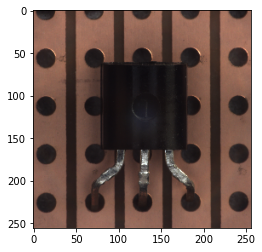

In [23]:
plt.imshow(x_train_ok[0])

In [24]:
x_train_flat = convert_flatten_img_arr(x_train)
x_train_flat.shape

(245, 196608)

In [25]:
x_test_flat = convert_flatten_img_arr(x_test)
x_test_flat.shape

(68, 196608)

In [26]:
'''
# Find best hyper-parameter using the Grid searh method
log_grid_params = {'penalty': ['l2', 'none', 'elasticnet'], 'max_iter': [250, 350, 500, 800]}
log_grid_search = GridSearchCV(LogisticRegression(), log_grid_params, verbose=4, cv=None, n_jobs=-1)   # 10 Fold cross validation, all threads are active, verbose high
log_grid_search.fit(x_train_flat, y_train)
vision.print_grid_search_results(log_grid_search)
'''

"\n# Find best hyper-parameter using the Grid searh method\nlog_grid_params = {'penalty': ['l2', 'none', 'elasticnet'], 'max_iter': [250, 350, 500, 800]}\nlog_grid_search = GridSearchCV(LogisticRegression(), log_grid_params, verbose=4, cv=None, n_jobs=-1)   # 10 Fold cross validation, all threads are active, verbose high\nlog_grid_search.fit(x_train_flat, y_train)\nvision.print_grid_search_results(log_grid_search)\n"

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       196609     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69821D+02    |proj g|=  9.05000D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****     40     48      1     0     0   6.294D-05   1.518D-04
  F =   1.5175646085332316E-004

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished


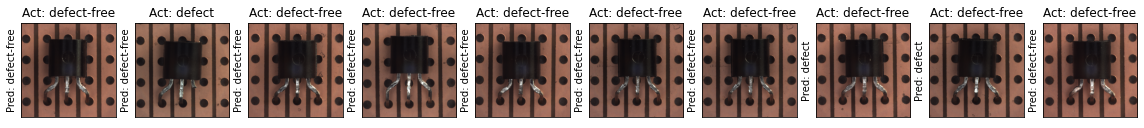

====== LogisticRegression model Evaluation metrics ======
Accuracy of model:      0.765
Recall of model:        0.765
Precision of model:     0.765
F1 score of model:      0.765
Misclassification Number:  16

====== LogisticRegression model Detailed Classification Report ======
              precision    recall  f1-score   support

      defect       0.21      0.38      0.27         8
 defect-free       0.91      0.82      0.86        60

    accuracy                           0.76        68
   macro avg       0.56      0.60      0.57        68
weighted avg       0.83      0.76      0.79        68

AUC:  0.7104166666666666
No-skill AUC:  0.5



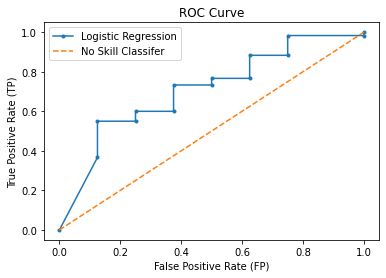

AUC:  0.9483401618530398



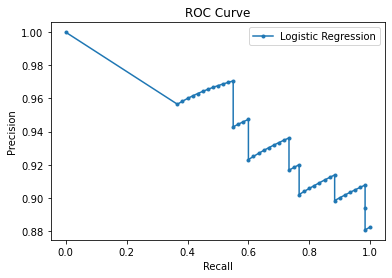

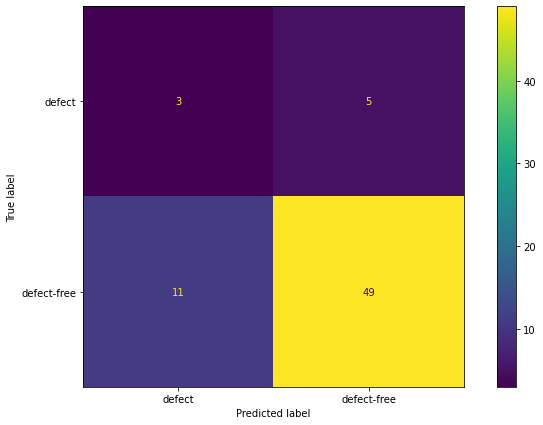

In [27]:
log_model = LogisticRegression(penalty='none', max_iter=250, verbose=1)
log_model.fit(x_train_flat, y_train)

y_pred_log = log_model.predict(x_test_flat)
log_pos_probs = (log_model.predict_proba(x_test_flat))[:,1]

vision.plot_randomly_img_predictions(x_test, y_test, y_pred_log, labels, num_item=10)

# Print Logistic Regression model's all Evaluation metrics for Test set (Accuracy, Recall, Precision, F1 score, Misclassification number)
vision.print_eval_parameters(log_model, y_test, y_pred_log, labels)

# Show Receiver Operating Characteristic Curve (ROC) Graph in order to show
# the performance of a classification model at all classification thresholds
# True Positive Rate (TPR) = TP / (TP + FN)
# False Positive Rate (FPR) = FP / (FP + TN)
vision.show_ROC_score(y_test, log_pos_probs, kind='fp_tp', plot=True, label="Logistic Regression")

# Show Precicision / Recall ROC curve
# Precision is the proportion of the positive results that were correctly classifier.
# Precision = TP / (TP + FP)
vision.show_ROC_score(y_test, log_pos_probs, kind='pre_rec', plot=True, label="Logistic Regression")

# Show Confusion Matrix for Logistic Regression model's prediction results for Test set
vision.show_confusion_matrix(y_test, y_pred_log, labels)

In [28]:
'''
# Find best hyper-parameter using the Grid searh method
decision_params = {'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random'], 'max_depth': [25, 50, 100, 500]}
decision_search = GridSearchCV(DecisionTreeClassifier(), decision_params, verbose=4, cv=None, n_jobs=-1)   # 10 Fold cross validation, all threads are active, verbose high
decision_search.fit(x_train_flat, y_train)
vision.print_grid_search_results(decision_search)
'''

"\n# Find best hyper-parameter using the Grid searh method\ndecision_params = {'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random'], 'max_depth': [25, 50, 100, 500]}\ndecision_search = GridSearchCV(DecisionTreeClassifier(), decision_params, verbose=4, cv=None, n_jobs=-1)   # 10 Fold cross validation, all threads are active, verbose high\ndecision_search.fit(x_train_flat, y_train)\nvision.print_grid_search_results(decision_search)\n"

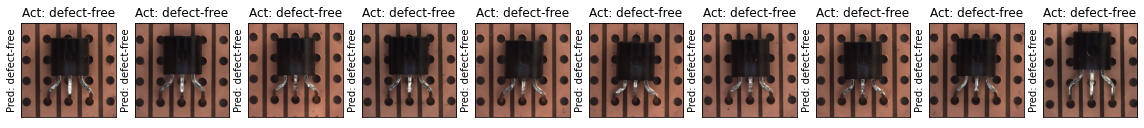

====== DecisionTreeClassifier model Evaluation metrics ======
Accuracy of model:      0.956
Recall of model:        0.956
Precision of model:     0.956
F1 score of model:      0.956
Misclassification Number:  3

====== DecisionTreeClassifier model Detailed Classification Report ======
              precision    recall  f1-score   support

      defect       0.73      1.00      0.84         8
 defect-free       1.00      0.95      0.97        60

    accuracy                           0.96        68
   macro avg       0.86      0.97      0.91        68
weighted avg       0.97      0.96      0.96        68

AUC:  0.975
No-skill AUC:  0.5



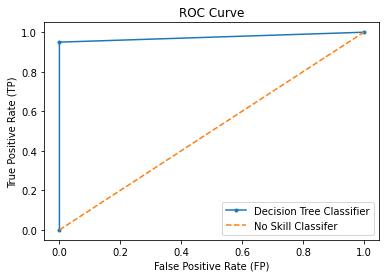

AUC:  0.9970588235294118



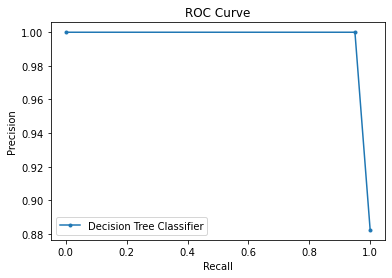

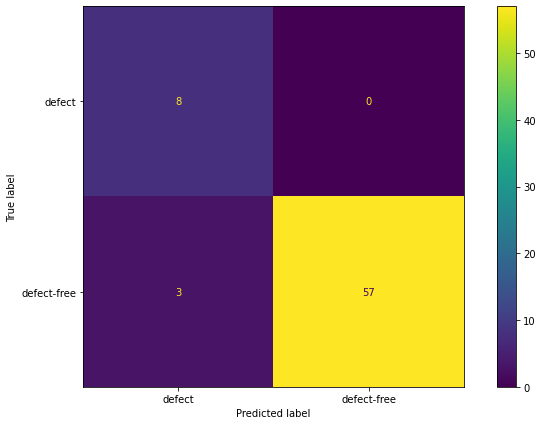

In [29]:
#decision_model = DecisionTreeClassifier(criterion='entropy', max_features=None, splitter='best', class_weight='balanced', random_state=RND_STATE)
decision_model = DecisionTreeClassifier(criterion='entropy', max_features=None, splitter='best', max_depth=50, random_state=RND_STATE)

decision_model.fit(x_train_flat, y_train)

y_pred_decision = decision_model.predict(x_test_flat)
dec_pos_probs = (decision_model.predict_proba(x_test_flat))[:,1]

vision.plot_randomly_img_predictions(x_test, y_test, y_pred_decision, labels, num_item=10)

# Print Decision Tree model's all Evaluation metrics for Validation set (Accuracy, Recall, Precision, F1 score, Misclassification number)
vision.print_eval_parameters(model=decision_model, y_test=y_test, y_pred=y_pred_decision, labels=labels)

# Show Receiver Operating Characteristic Curve (ROC) Graph in order to show
# the performance of a classification model at all classification thresholds
# True Positive Rate (TPR) = TP / (TP + FN)
# False Positive Rate (FPR) = FP / (FP + TN)
vision.show_ROC_score(y_test, dec_pos_probs, kind='fp_tp', plot=True, label="Decision Tree Classifier")

# Show Precicision / Recall ROC curve
# Precision is the proportion of the positive results that were correctly classifier.
# Precision = TP / (TP + FP)
vision.show_ROC_score(y_test, dec_pos_probs, kind='pre_rec', plot=True, label="Decision Tree Classifier")

# Show Confusion Matrix for Decision Tree model's prediction results for Validation
vision.show_confusion_matrix(y_test, y_pred_decision, labels)

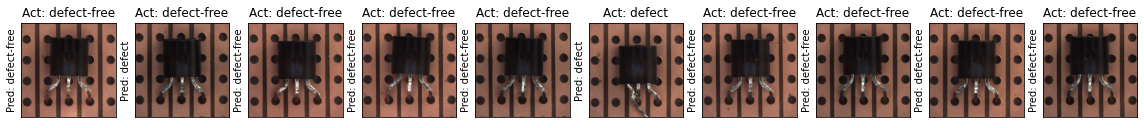

====== GaussianNB model Evaluation metrics ======
Accuracy of model:      0.897
Recall of model:        0.897
Precision of model:     0.897
F1 score of model:      0.897
Misclassification Number:  7

====== GaussianNB model Detailed Classification Report ======
              precision    recall  f1-score   support

      defect       0.60      0.38      0.46         8
 defect-free       0.92      0.97      0.94        60

    accuracy                           0.90        68
   macro avg       0.76      0.67      0.70        68
weighted avg       0.88      0.90      0.89        68

AUC:  0.6708333333333334
No-skill AUC:  0.5



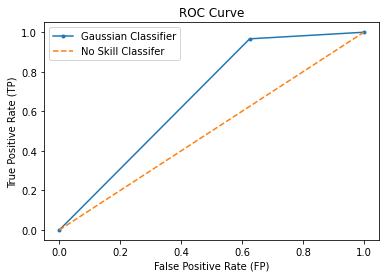

AUC:  0.9583566760037348



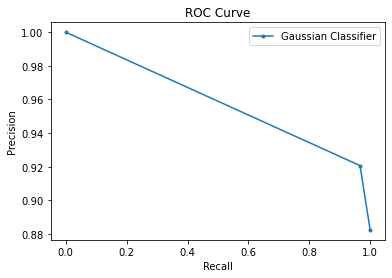

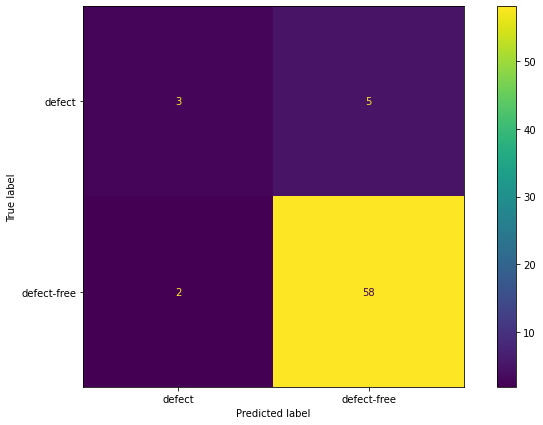

In [30]:
# Naive Bayes Classification algorithm implementation
naive_model = GaussianNB()

# Training the Naive Bayes model with scaled training data using validation set
naive_model.fit(x_train_flat, y_train)

# Naive Bayes model Prediction process for validation set
y_pred_naive = naive_model.predict(x_test_flat)
naive_pos_probs = (naive_model.predict_proba(x_test_flat))[:,1]

vision.plot_randomly_img_predictions(x_test, y_test, y_pred_naive, labels, num_item=10)

# Print Naive Bayes model's all Evaluation metrics for validation set (Accuracy, Recall, Precision, F1 score, Misclassification number)
vision.print_eval_parameters(model=naive_model, y_test=y_test, y_pred=y_pred_naive, labels=labels)

# Show Receiver Operating Characteristic Curve (ROC) Graph in order to show
# the performance of a classification model at all classification thresholds
# True Positive Rate (TPR) = TP / (TP + FN)
# False Positive Rate (FPR) = FP / (FP + TN)
vision.show_ROC_score(y_test, naive_pos_probs, kind='fp_tp', plot=True, label="Gaussian Classifier")

# Show Precicision / Recall ROC curve
# Precision is the proportion of the positive results that were correctly classifier.
# Precision = TP / (TP + FP)
vision.show_ROC_score(y_test, naive_pos_probs, kind='pre_rec', plot=True, label="Gaussian Classifier")

# Show Confusion Matrix for Naive Bayes model's prediction results 
vision.show_confusion_matrix(y_test, y_pred_naive, labels)

In [31]:
'''
# Find best hyper-parameter using the Grid searh method
svm_params = {'kernel': ['linear', 'poly', 'rbf'], 'C': [1, 0.1, 0.01, 0.001], 'class_weight': [None, 'balanced']}
svm_search = GridSearchCV(SVC(), svm_params, verbose=4, cv=None, n_jobs=-1)   # 10 Fold cross validation, all threads are active, verbose high
svm_search.fit(x_train_flat, y_train)
vision.print_grid_search_results(svm_search)
'''

"\n# Find best hyper-parameter using the Grid searh method\nsvm_params = {'kernel': ['linear', 'poly', 'rbf'], 'C': [1, 0.1, 0.01, 0.001], 'class_weight': [None, 'balanced']}\nsvm_search = GridSearchCV(SVC(), svm_params, verbose=4, cv=None, n_jobs=-1)   # 10 Fold cross validation, all threads are active, verbose high\nsvm_search.fit(x_train_flat, y_train)\nvision.print_grid_search_results(svm_search)\n"

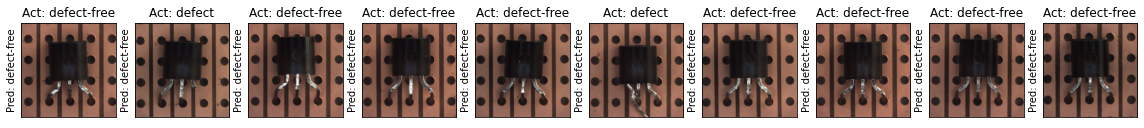

====== SVC model Evaluation metrics ======
Accuracy of model:      0.882
Recall of model:        0.882
Precision of model:     0.882
F1 score of model:      0.882
Misclassification Number:  8

====== SVC model Detailed Classification Report ======
              precision    recall  f1-score   support

      defect       0.50      0.25      0.33         8
 defect-free       0.91      0.97      0.94        60

    accuracy                           0.88        68
   macro avg       0.70      0.61      0.63        68
weighted avg       0.86      0.88      0.86        68

AUC:  0.6708333333333334
No-skill AUC:  0.5



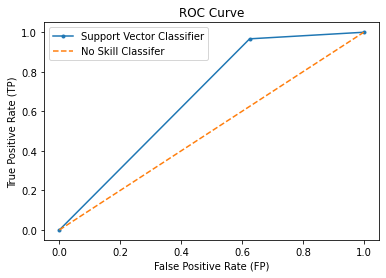

AUC:  0.9583566760037348



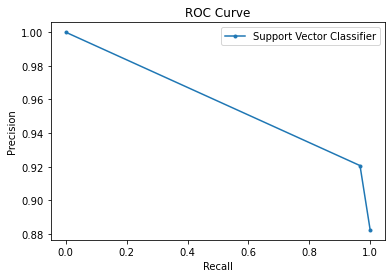

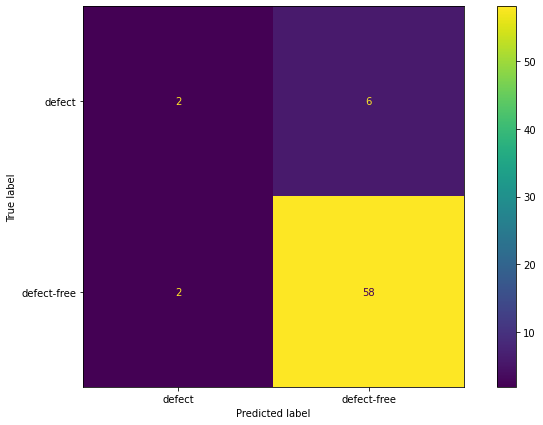

In [32]:
# Support Vector Machine Classification algorithm implementation
svm_model = SVC(kernel="linear",class_weight=None, C=0.001, random_state=0)

# Training the SVC model with scaled training data using validation set
svm_model.fit(x_train_flat, y_train)

# SVC model Prediction process for validation set
y_pred_svc = svm_model.predict(x_test_flat)
svc_pos_probs = (naive_model.predict_proba(x_test_flat))[:,1]

vision.plot_randomly_img_predictions(x_test, y_test, y_pred_svc, labels, num_item=10)

# Print SVC model's all Evaluation metrics for validation set (Accuracy, Recall, Precision, F1 score, Misclassification number)
vision.print_eval_parameters(model=svm_model, y_test=y_test, y_pred=y_pred_svc, labels=labels)

# Show Receiver Operating Characteristic Curve (ROC) Graph in order to show
# the performance of a classification model at all classification thresholds
# True Positive Rate (TPR) = TP / (TP + FN)
# False Positive Rate (FPR) = FP / (FP + TN)
vision.show_ROC_score(y_test, svc_pos_probs, kind='fp_tp', plot=True, label="Support Vector Classifier")

# Show Precicision / Recall ROC curve
# Precision is the proportion of the positive results that were correctly classifier.
# Precision = TP / (TP + FP)
vision.show_ROC_score(y_test, svc_pos_probs, kind='pre_rec', plot=True, label="Support Vector Classifier")

# Show Confusion Matrix for SVC model's prediction results 
vision.show_confusion_matrix(y_test, y_pred_svc, labels)

In [33]:
'''
# Find best hyper-parameter using the Grid searh method
rnd_frst_params = {'criterion': ['gini', 'entropy', 'log_loss'], 'n_estimators': [50, 100, 200, 500], 'max_depth': [25, 50, 100, 500]}
rnd_frst_search = GridSearchCV(RandomForestClassifier(), rnd_frst_params, verbose=4, cv=None, n_jobs=-1)   # 10 Fold cross validation, all threads are active, verbose high
rnd_frst_search.fit(x_train_flat, y_train)
vision.print_grid_search_results(rnd_frst_search)
'''

"\n# Find best hyper-parameter using the Grid searh method\nrnd_frst_params = {'criterion': ['gini', 'entropy', 'log_loss'], 'n_estimators': [50, 100, 200, 500], 'max_depth': [25, 50, 100, 500]}\nrnd_frst_search = GridSearchCV(RandomForestClassifier(), rnd_frst_params, verbose=4, cv=None, n_jobs=-1)   # 10 Fold cross validation, all threads are active, verbose high\nrnd_frst_search.fit(x_train_flat, y_train)\nvision.print_grid_search_results(rnd_frst_search)\n"

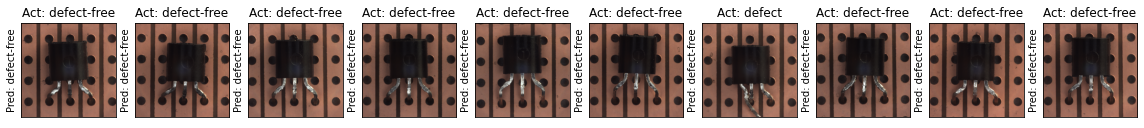

====== RandomForestClassifier model Evaluation metrics ======
Accuracy of model:      0.912
Recall of model:        0.912
Precision of model:     0.912
F1 score of model:      0.912
Misclassification Number:  6

====== RandomForestClassifier model Detailed Classification Report ======
              precision    recall  f1-score   support

      defect       1.00      0.25      0.40         8
 defect-free       0.91      1.00      0.95        60

    accuracy                           0.91        68
   macro avg       0.95      0.62      0.68        68
weighted avg       0.92      0.91      0.89        68

AUC:  0.9375
No-skill AUC:  0.5



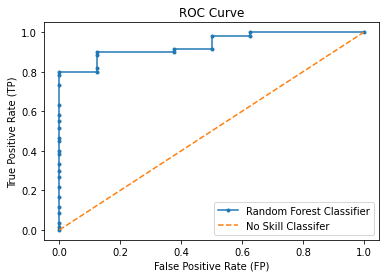

AUC:  0.9915393815519148



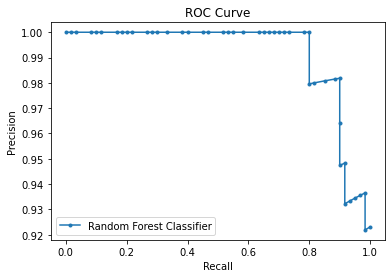

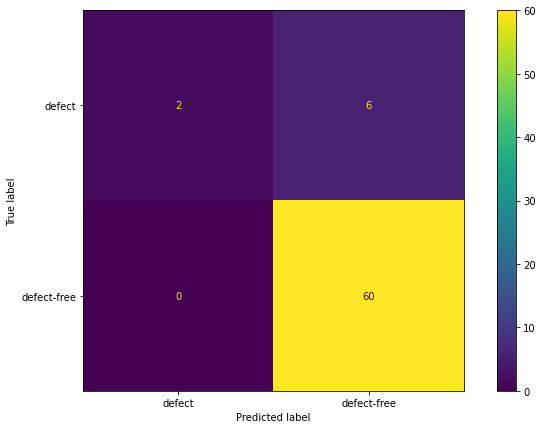

In [34]:
# Random Forest Classification algorithm implementation
rnd_frst_model = RandomForestClassifier(criterion='entropy', n_estimators=200, max_depth=100, random_state=0)

# Training the Random Forest model with scaled training data using validation set
rnd_frst_model.fit(x_train_flat, y_train)

# Random Forest model Prediction process for validation set
y_pred_rnd_forest = rnd_frst_model.predict(x_test_flat)
rnd_pos_probs = (rnd_frst_model.predict_proba(x_test_flat))[:,1]

vision.plot_randomly_img_predictions(x_test, y_test, y_pred_rnd_forest, labels, num_item=10)

# Print Random Forest model's all Evaluation metrics for validation set (Accuracy, Recall, Precision, F1 score, Misclassification number)
vision.print_eval_parameters(model=rnd_frst_model, y_test=y_test, y_pred=y_pred_rnd_forest, labels=labels)

# Show Receiver Operating Characteristic Curve (ROC) Graph in order to show
# the performance of a classification model at all classification thresholds
# True Positive Rate (TPR) = TP / (TP + FN)
# False Positive Rate (FPR) = FP / (FP + TN)
vision.show_ROC_score(y_test, rnd_pos_probs, kind='fp_tp', plot=True, label="Random Forest Classifier")

# Show Precicision / Recall ROC curve
# Precision is the proportion of the positive results that were correctly classifier.
# Precision = TP / (TP + FP)
vision.show_ROC_score(y_test, rnd_pos_probs, kind='pre_rec', plot=True, label="Random Forest Classifier")

# Show Confusion Matrix for Random Forest model's prediction results 
vision.show_confusion_matrix(y_test, y_pred_rnd_forest, labels)

In [35]:
'''
# Find best hyper-parameter using the Grid searh method
kNN_params = {'n_neighbors': [1, 3, 5], 'weights': ['uniform', 'distance'], 'p': [1, 2]}
kNN_search = GridSearchCV(KNeighborsClassifier(), kNN_params, verbose=4, cv=None, n_jobs=-1)   # 10 Fold cross validation, all threads are active, verbose high
kNN_search.fit(x_train_flat, y_train)
vision.print_grid_search_results(kNN_search)
'''

"\n# Find best hyper-parameter using the Grid searh method\nkNN_params = {'n_neighbors': [1, 3, 5], 'weights': ['uniform', 'distance'], 'p': [1, 2]}\nkNN_search = GridSearchCV(KNeighborsClassifier(), kNN_params, verbose=4, cv=None, n_jobs=-1)   # 10 Fold cross validation, all threads are active, verbose high\nkNN_search.fit(x_train_flat, y_train)\nvision.print_grid_search_results(kNN_search)\n"

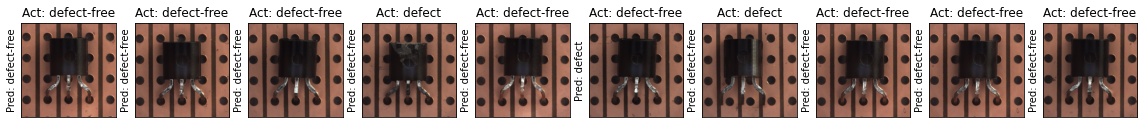

====== KNeighborsClassifier model Evaluation metrics ======
Accuracy of model:      0.765
Recall of model:        0.765
Precision of model:     0.765
F1 score of model:      0.765
Misclassification Number:  16

====== KNeighborsClassifier model Detailed Classification Report ======
              precision    recall  f1-score   support

      defect       0.00      0.00      0.00         8
 defect-free       0.87      0.87      0.87        60

    accuracy                           0.76        68
   macro avg       0.43      0.43      0.43        68
weighted avg       0.76      0.76      0.76        68

AUC:  0.4
No-skill AUC:  0.5



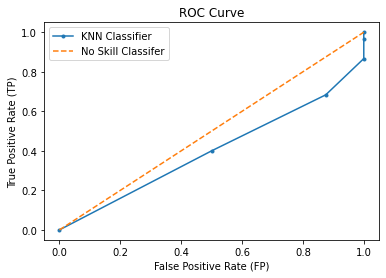

AUC:  0.8882322171292759



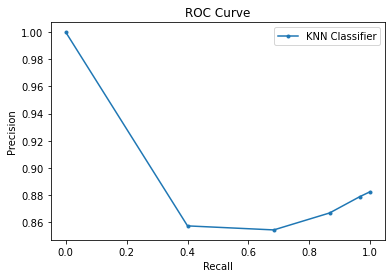

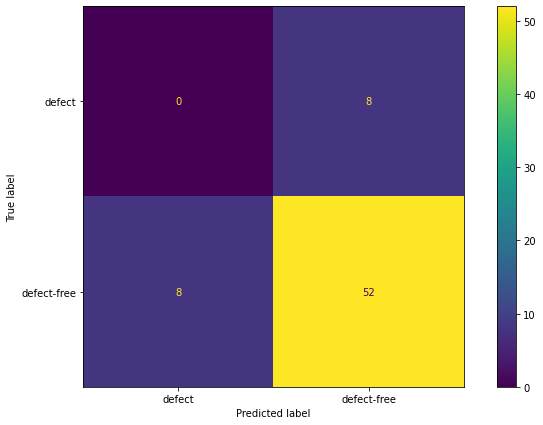

In [40]:
# K-Nearest Neighbors Classification algorithm implementation
# We used 'minkowski' distance metric and set power parameter(p) to 2.
# Minkowski metric: sum(w * |x - y|^p)^(1/p)
# For p = 2, we get standard euclidean metric: sqrt(sum((x - y)^2))
kNN_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric="minkowski", p=1)

# Training the K Nearest Neighbor model with scaled training data using validation set
kNN_model.fit(x_train_flat, y_train)

# K Nearest Neighbor model Prediction process for validation set
y_pred_knn = kNN_model.predict(x_test_flat)
kNN_pos_probs = (kNN_model.predict_proba(x_test_flat))[:,1]

vision.plot_randomly_img_predictions(x_test, y_test, y_pred_knn, labels, num_item=10)

# Print K Nearest Neighbor model's all Evaluation metrics for validation set (Accuracy, Recall, Precision, F1 score, Misclassification number)
vision.print_eval_parameters(model=kNN_model, y_test=y_test, y_pred=y_pred_knn, labels=labels)

# Show Receiver Operating Characteristic Curve (ROC) Graph in order to show
# the performance of a classification model at all classification thresholds
# True Positive Rate (TPR) = TP / (TP + FN)
# False Positive Rate (FPR) = FP / (FP + TN)
vision.show_ROC_score(y_test, kNN_pos_probs, kind='fp_tp', plot=True, label="KNN Classifier")

# Show Precicision / Recall ROC curve
# Precision is the proportion of the positive results that were correctly classifier.
# Precision = TP / (TP + FP)
vision.show_ROC_score(y_test, kNN_pos_probs, kind='pre_rec', plot=True, label="KNN Classifier")

# Show Confusion Matrix for K Nearest Neighbor model's prediction results 
vision.show_confusion_matrix(y_test, y_pred_knn, labels)